In [30]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
tf.test.is_built_with_cuda()
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import pyarrow.parquet as pq


from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.transforms import Compose
import random
# Set the seed value all over the place to make this reproducible.
seed_val = 42


random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
import time
import datetime
import csv


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def enum_parameters(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        total_params+=params
    print(f"Total Trainable Params: {total_params}")
    return total_params


In [21]:
class WindowedGaitDataset(Dataset):
    """Windowed Gait dataset."""

    def __init__(self, gait_data, window_size_kinematics=50, window_size_gait_state=1,
                 meas_scale=None, speed_scale=None, incline_scale=None, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            window_size_kinematics (integer): size of the window to apply to the kinematics data
            window_size_gait_state (integer): size of the window to apply to the gaits tate data, must be smaller than window_size_kinematics
            speed_scale (tuple, optional): A 2-tuple of the lower and upper bounds to scale the speed
            incline_scale (tuple, optional): A 2-tuple of the lower and upper bounds to scale the incline
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.gait_data = gait_data
        self.window_size_kinematics = window_size_kinematics
        self.window_size_gait_state = window_size_gait_state
        
        assert(self.window_size_kinematics >= self.window_size_gait_state)
        
        self.meas_scale = meas_scale
        self.speed_scale = speed_scale
        self.incline_scale = incline_scale
        self.transform = transform

    def __len__(self):
        return len(self.gait_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if idx < self.window_size_kinematics and idx >= 0:
          # idx = len(self.gait_data)-1
          idx = random.randint(self.window_size_kinematics, len(self.gait_data)-1)
          # print('saturating')


        meas_idxs = [0,1,2,3,4,5,14]

        #phase, speed, incline, is_stairs, is_moving
        gait_state_idxs = [6,7,8,9,10]    
        measurements = self.gait_data.iloc[idx-self.window_size_kinematics:idx,meas_idxs].to_numpy()
        
        gait_states = self.gait_data.iloc[idx-self.window_size_gait_state:idx,gait_state_idxs].to_numpy()

        #bound the accel measurements to remove large (likey numerical deriv. related) spikes
        measurements[:,4] = np.clip(measurements[:,4],-100,100)
        measurements[:,5] = np.clip(measurements[:,5],-100,100)


        
        if self.meas_scale is not None:
            for i in range(len(meas_idxs)):
                lb = self.meas_scale[i,0]
                ub = self.meas_scale[i,1]
                measurements[:,i] = ((1 - 0)/(ub - lb)) * (measurements[:,i] - lb)
        
        
        if self.speed_scale:
            lb = self.speed_scale[0]
            ub = self.speed_scale[1]
            gait_states[:,1] = ((1 - 0)/(ub - lb)) * (gait_states[:,1] - lb)

        if self.incline_scale:
            lb = self.incline_scale[0]
            ub = self.incline_scale[1]
            gait_states[:,2] = ((1 - 0)/(ub - lb)) * (gait_states[:,2] - lb)

        #convert phase to trig encoding to ensure continuous estimation
        phase_as_angle = 2*np.pi*(gait_states[:,0]-0.5)
        cp = np.cos(phase_as_angle)
        sp = np.sin(phase_as_angle)
        gait_states_new = np.zeros((gait_states.shape[0], gait_states.shape[1]+1))
        gait_states_new[:,0] = cp
        gait_states_new[:,1] = sp
        gait_states_new[:,2:] = gait_states[:,1:]
        gait_states = gait_states_new
        
        

        sample = {'meas': measurements, 'state': gait_states}

        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
class ReshapeForST(object):
    """Reshapes (window_size, ninvars) np array into flattened array for MGM"""
    
    def __call__(self, sample):
        meas, state = sample['meas'], sample['state']
        
        #flatten measurements
        #[[x0,y0],[x1,y1]] -> [[x0],[y0],[x1],[y1]]
        meas = meas.flatten().reshape(-1,1)
        
        #flatten gait_states
        state = state.flatten().reshape(-1,1)
        
        return {'meas': meas, 
                'state': state}
        
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        meas, state = sample['meas'], sample['state']
       
        meas = torch.from_numpy(meas).float()
        state = torch.from_numpy(state).float()

        return {'meas': meas, 
                'state': state}




In [3]:
#RUN THIS ON COLAB
ON_COLAB = False
if ON_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    drive_path = '/content/drive/MyDrive/Phase ML Data/'

In [44]:
window_size_kinematics = 50
window_size_gait_state = 1

meas_scale = np.array([[-69.35951035,  27.62815047],\
                        [-456.18013759,  401.13782617],\
                        [-63.71649984,  22.06632622],\
                        [-213.4786175,   396.93801619],\
                        [-35.26603985,  20.78473636],\
                        [-20.95456523,  14.63961137],\
                          [0,1]])

speed_scale = (0,2)
incline_scale = (-10,10)

filename_dataport_ordered = 'dataport_ordered_corrupt_time.csv'
filename_dataport_randomized = 'dataport_randomized_corrupt_time.csv'

filename_r01_ordered = 'r01_ordered_corrupt_time.csv'
filename_r01_randomized = 'r01_randomized_corrupt_time.csv'

filename_gt_ordered = 'gt_ordered_corrupt_time.csv'
filename_gt_randomized = 'gt_randomized_corrupt_time.csv'

if ON_COLAB:
    filename_r01_ordered = drive_path+filename_r01_ordered
    filename_r01_randomized = drive_path+filename_r01_randomized
    filename_dataport_ordered = drive_path+filename_dataport_ordered
    filename_dataport_randomized = drive_path+filename_dataport_randomized
    filename_gt_ordered = drive_path+filename_gt_ordered
    filename_gt_randomized = drive_path+filename_gt_randomized
    

gait_data_r01_randomized = pd.read_csv(filename_r01_randomized)
gait_data_r01_ordered = pd.read_csv(filename_r01_ordered)
gait_data_dataport_ordered = pd.read_csv(filename_dataport_ordered)
gait_data_dataport_randomized = pd.read_csv(filename_dataport_randomized)
gait_data_gt_ordered = pd.read_csv(filename_gt_ordered)
gait_data_gt_randomized = pd.read_csv(filename_gt_randomized)


# REMOVE RANDOM SUBJECTS FOR X-VALIDATION
#FROM R01, remove two: AB02 and AB06
#FROM DATAPORT, remove three: AB09, AB05, and AB10
#FROM GT, remove six, AB25, AB28, AB30, AB20, AB12, AB09
REMOVE_SUBS_XVAL = True

if REMOVE_SUBS_XVAL:
    #r01 ordered
    index_sub_remove_r01 = gait_data_r01_ordered[ (gait_data_r01_ordered['subj_id'] == 2) | (gait_data_r01_ordered['subj_id'] == 6) ].index
    gait_data_r01_ordered_val = gait_data_r01_ordered.iloc[index_sub_remove_r01]
    gait_data_r01_ordered.drop(index_sub_remove_r01 , inplace=True)
    
    #r01 randomized
    index_sub_remove_r01 = gait_data_r01_randomized[ (gait_data_r01_randomized['subj_id'] == 2) | (gait_data_r01_randomized['subj_id'] == 6) ].index
    gait_data_r01_randomized_val = gait_data_r01_randomized.iloc[index_sub_remove_r01]
    gait_data_r01_randomized.drop(index_sub_remove_r01 , inplace=True)
    
    print(gait_data_r01_ordered.head())
    print(gait_data_r01_ordered_val.head())
    
    #dataport ordered
    index_sub_remove_dataport = gait_data_dataport_ordered[ (gait_data_dataport_ordered['subj_id'] == 9) | 
                                                           (gait_data_dataport_ordered['subj_id'] == 5) |
                                                          (gait_data_dataport_ordered['subj_id'] == 10)].index

    gait_data_dataport_ordered_val = gait_data_dataport_ordered.iloc[index_sub_remove_dataport]
    gait_data_dataport_ordered.drop(index_sub_remove_dataport , inplace=True)
    
    #dataport randomized
    index_sub_remove_dataport = gait_data_dataport_randomized[ (gait_data_dataport_randomized['subj_id'] == 9) | 
                                                           (gait_data_dataport_randomized['subj_id'] == 5) |
                                                          (gait_data_dataport_randomized['subj_id'] == 10)].index

    gait_data_dataport_randomized_val = gait_data_dataport_randomized.iloc[index_sub_remove_dataport]
    gait_data_dataport_randomized.drop(index_sub_remove_dataport , inplace=True)
    
    #gt ordered
    index_sub_remove_gt = gait_data_gt_ordered[ (gait_data_gt_ordered['subj_id'] == 25) | 
                                               (gait_data_gt_ordered['subj_id'] == 28) |
                                              (gait_data_gt_ordered['subj_id'] == 30) |
                                              (gait_data_gt_ordered['subj_id'] == 20) |
                                              (gait_data_gt_ordered['subj_id'] == 12) |
                                              (gait_data_gt_ordered['subj_id'] == 9)].index
    
    gait_data_gt_ordered_val = gait_data_gt_ordered.iloc[index_sub_remove_gt]
    gait_data_gt_ordered.drop(index_sub_remove_gt , inplace=True)
    
    #gt randomized
    index_sub_remove_gt = gait_data_gt_randomized[ (gait_data_gt_randomized['subj_id'] == 25) | 
                                               (gait_data_gt_randomized['subj_id'] == 28) |
                                              (gait_data_gt_randomized['subj_id'] == 30) |
                                              (gait_data_gt_randomized['subj_id'] == 20) |
                                              (gait_data_gt_randomized['subj_id'] == 12) |
                                              (gait_data_gt_randomized['subj_id'] == 9)].index
    
    gait_data_gt_randomized_val = gait_data_gt_randomized.iloc[index_sub_remove_gt]
    gait_data_gt_randomized.drop(index_sub_remove_gt , inplace=True)
    
    # concatenate
    gait_data = pd.concat([gait_data_r01_ordered, gait_data_r01_randomized,\
                          gait_data_dataport_ordered, gait_data_dataport_randomized,\
                          gait_data_gt_ordered, gait_data_gt_randomized])
    
    gait_data_val = pd.concat([gait_data_r01_ordered_val, gait_data_r01_randomized_val,\
                              gait_data_dataport_ordered_val, gait_data_dataport_randomized_val,\
                              gait_data_gt_ordered_val, gait_data_gt_randomized_val])
    
#     gait_data = pd.concat([gait_data_r01_ordered, gait_data_r01_randomized,\
#                           gait_data_dataport_ordered, gait_data_dataport_randomized])
    
#     gait_data_val = pd.concat([gait_data_r01_ordered_val, gait_data_r01_randomized_val,\
#                               gait_data_dataport_ordered_val, gait_data_dataport_randomized_val])
    
    train_dataset = WindowedGaitDataset(gait_data=gait_data,
                                                meas_scale=meas_scale,
                                                window_size_kinematics = window_size_kinematics,
                                                window_size_gait_state = window_size_gait_state,
                                                speed_scale = speed_scale,
                                                incline_scale = incline_scale,
                                                transform=Compose([ReshapeForST(), ToTensor()]))
    
    val_dataset = WindowedGaitDataset(gait_data=gait_data_val,
                                                meas_scale=meas_scale,
                                                window_size_kinematics = window_size_kinematics,
                                                window_size_gait_state = window_size_gait_state,
                                                speed_scale = speed_scale,
                                                incline_scale = incline_scale,
                                                transform=Compose([ReshapeForST(), ToTensor()]))
    
    print('{:>5,} training samples'.format(len(train_dataset)))
    print('{:>5,} validation samples'.format(len(val_dataset)))


else:
    gait_data = pd.concat([gait_data_r01_ordered, gait_data_r01_randomized,\
                          gait_data_dataport_ordered, gait_data_dataport_randomized,\
                          gait_data_gt_ordered, gait_data_gt_randomized])
    # gait_data = gait_data_r01_randomized
    # gait_data = pd.concat([gait_data_r01_randomized, gait_data_dataport_randomized])
    
    dataset = WindowedGaitDataset(gait_data=gait_data,
                                            meas_scale=meas_scale,
                                            window_size_kinematics = window_size_kinematics,
                                            window_size_gait_state = window_size_gait_state,
                                            speed_scale = speed_scale,
                                            incline_scale = incline_scale,
                                            transform=Compose([ReshapeForST(), ToTensor()]))  
    # Create a 90-10 train-validation split.

    # Calculate the number of samples to include in each set.
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size


    # Divide the dataset by randomly selecting samples.
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    print('{:>5,} training samples'.format(train_size))
    print('{:>5,} validation samples'.format(val_size))

print(val_dataset[0]['meas'][-1,:])
print(val_dataset[1]['meas'][-1,:])
print(val_dataset[2]['meas'][-1,:])

print(val_dataset[0]['state'][:,0])






   foot_angle  foot_vel_angle  shank_angle  shank_vel_angle  heel_acc_forward  \
0    9.713109     -122.000000     6.810365       -54.155000          0.000000   
1    7.928249     -133.739183     5.993880       -61.785706         -3.391320   
2    7.120444     -147.077747     5.606053       -70.516308         -7.078094   
3    5.217823     -162.450106     4.621966       -84.205665         -3.548601   
4    3.440199     -167.100286     3.626258       -93.718654         -1.555049   

   heel_acc_upward     phase  speed  incline  is_stairs  is_moving  \
0         0.000000  0.000968    0.8    -10.0        0.0        1.0   
1         2.057084  0.013282    0.8    -10.0        0.0        1.0   
2         4.304541  0.018221    0.8    -10.0        0.0        1.0   
3         2.657375  0.028783    0.8    -10.0        0.0        1.0   
4         1.422208  0.038366    0.8    -10.0        0.0        1.0   

   stride_count  HSDetected  subj_id        dt      time  
0             1           1      

In [23]:
#SET BATCH SIZE
BATCH_SIZE_TRAIN = 256//4
BATCH_SIZE_VALIDATE = 1024//4
# NUM_WORKERS = 8
NUM_WORKERS = 2

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            shuffle=True,
            batch_size = BATCH_SIZE_TRAIN, # Trains with this batch size.
            pin_memory=True,
            num_workers=NUM_WORKERS
        )


# For validation the order doesn't matter, so we'll just read them sequentially.
#try shuffle off see if it fixes
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            shuffle=True,
            batch_size = BATCH_SIZE_VALIDATE, # Evaluate with this batch size.
            pin_memory=True,
            num_workers=NUM_WORKERS
        )

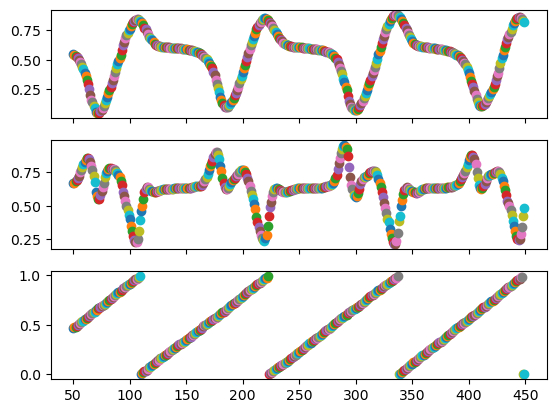

In [55]:
fig, axs = plt.subplots(3,1,sharex=True)

ninvars = 7 #just for plotting
for i in range(window_size_kinematics,window_size_kinematics+400):
    y = train_dataset[i]['meas'][0::ninvars,0]
    y1 = train_dataset[i]['meas'][4::ninvars,0]
    x = np.array([j for j in range(len(y))])
    x = x + i 

    cp = train_dataset[i]['state'][0::6,0]
    sp = train_dataset[i]['state'][1::6,0]
    #undo the trig on phase
    at2 = np.arctan2(sp,cp)
    phase_p = ((at2)/(2*np.pi)) + 0.5

    axs[0].plot(i,y[-1],'o',linewidth=3)
    axs[1].plot(i,y1[-1],'o',linewidth=3)
    axs[2].plot(i,phase_p[-1],'o',linewidth=3)

In [56]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

# model_nickname = 'apollyon'
model_nickname = 'ST-keter'

output_dir = f'./staging_area/{model_nickname}/model_save/'
if REMOVE_SUBS_XVAL:
    output_dir = f'./staging_area/{model_nickname}/model_save_xval/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

checkpoint_dir = 'checkpoints/'
if not os.path.exists(output_dir+checkpoint_dir):
    os.makedirs(output_dir+checkpoint_dir)


class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(self, path, best_valid_loss=float('inf')):
        self.path = path
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, loss_fcn
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch}\n")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': current_valid_loss,
                }, self.path)



Saving model to ./staging_area/ST-keter/model_save_xval/


In [61]:
def project_variable_idxs_across_cols(variable_idxs, seq_len, num_variables):
    """
    Projects ordered indexes of the input kinematics across all the rows
    of the spatiotemporal encoder sequence

    e.g. assume we have e = [x1, y1]
                            [x2, y2]

         with t1 at 1 and t2 at 2
        and we want to index all the y's, 
        this returns the indexes of the y's assuming that e is flattened as
                e_flat = [x1,y1,x2,y2]^T

    Args:
        variable_idxs: list of the columns for the kinematics

    Return:
        a list of the indexes for the encoder sequence corresponding to the desired
        variables            
    """

    variable_col_idxs = []

    for idx in variable_idxs:
        variable_col_idxs.extend(range(idx, seq_len, num_variables))

    variable_col_idxs.sort()

    return variable_col_idxs

def generate_square_subsequent_mask(dim1: int, dim2: int) -> Tensor:
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.
    Source:
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    Args:
        dim1: int, for both src and tgt masking, this must be target sequence
              length
        dim2: int, for src masking this must be encoder sequence length (i.e. 
              the length of the input sequence to the model), 
              and for tgt masking, this must be target sequence length 
    Return:
        A Tensor of shape [dim1, dim2]
    """
    return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1)
    
class PositionalEncoder(nn.Module):
    """
    The authors of the original transformer paper describe very succinctly what 
    the positional encoding layer does and why it is needed:
    
    "Since our model contains no recurrence and no convolution, in order for the 
    model to make use of the order of the sequence, we must inject some 
    information about the relative or absolute position of the tokens in the 
    sequence." (Vaswani et al, 2017)
    Adapted from: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(
        self, 
        dropout: float=0.1, 
        max_seq_len: int=9000, 
        d_model: int=512,
        batch_first: bool=True,
        num_input_variables: int=7,
        ):

        """
        Parameters:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model 
                     (Vaswani et al, 2017)
        """

        super().__init__()

        self.d_model = d_model
        
        self.dropout = nn.Dropout(p=dropout)

        self.batch_first = batch_first
        self.max_seq_len = max_seq_len
        self.x_dim = 1 if batch_first else 0
        self.num_input_variables = num_input_variables
        pe = torch.zeros((1,max_seq_len,d_model))
        self.register_buffer('pe', pe, persistent=False)
        # print(self.pe.get_device() )
        


        
    def forward(self, x: Tensor, dts: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or 
               [enc_seq_len, batch_size, dim_val]
        """
        self.pe = torch.zeros(x.shape,device=self.pe.device)
        #dts should be (batch_size, 250, 1)
        # print('2')
        # print(dts)
        # print(dts.shape)
        # input()
        t_rel = torch.cumsum(torch.flip(dts, [1]), dim=1)

        #flip order so most recent dt is last
        t_rel = torch.flip(t_rel, [1])

        #repeat each element of the time embedding n_input times
        t_rel = torch.repeat_interleave(t_rel,self.num_input_variables,dim=1)
        # print('t_rel')
        # print(t_rel.shape)
        # print(t_rel)
        # print(self.pe.get_device() )
        
        #the embedding for the most recent (last in the list) entry
        #should have a zero time step
        self.pe[:,:-self.num_input_variables,:] = t_rel[:,self.num_input_variables:,:]
        
        # print('pe')
        # print(self.pe.shape)
        # print(self.pe[0,:,0])
        # input()
        
        # print(x.get_device() )

        x = x + self.pe

        return self.dropout(x)


class VariableEmbedding(nn.Module):
    """
    The authors of the original transformer paper describe very succinctly what 
    the positional encoding layer does and why it is needed:
    
    "Since our model contains no recurrence and no convolution, in order for the 
    model to make use of the order of the sequence, we must inject some 
    information about the relative or absolute position of the tokens in the 
    sequence." (Vaswani et al, 2017)
    Adapted from: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(
        self, 
        seq_len: int=50, 
        num_input_variables: int=5,
        d_model: int=512,
        batch_first: bool=True,
        ):

        """
        Parameters:
            enc_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model 
                     (Vaswani et al, 2017)
        """

        super().__init__()

        self.d_model = d_model
        self.batch_first = batch_first
        self.seq_len = seq_len
        self.num_input_variables = num_input_variables
        self.x_dim = 1 if batch_first else 0

        var_idx = torch.arange(self.num_input_variables)
        var_idx = var_idx.repeat(self.seq_len//self.num_input_variables)
        self.register_buffer('var_idx', var_idx, persistent=False)

        #create variable index encoder
        self.variable_embedding = nn.Embedding(num_embeddings=num_input_variables, embedding_dim=d_model)
        
        
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, (enc_seq_len*dim_val)]
        """
        

        v_embed = self.variable_embedding(self.var_idx)

        return x + v_embed

class GaitTransformerSpatiotemporalEncoder(nn.Module):

    def __init__(self, 
        input_size: int,
        num_input_variables: int,
        batch_first: bool=True,
        dim_val: int=512,  
        n_encoder_layers: int=4,
        n_heads: int=8,
        enc_seq_len: int=50,
        dropout_encoder: float=0, 
        dropout_pos_enc: float=0,
        dim_feedforward_encoder: int=128,
        IS_BEING_TRAINED: bool=False
        ): 

        """
        Args:
            input_size: int, number of input variables. 1 if univariate.
            dec_seq_len: int, the length of the input sequence fed to the decoder
            dim_val: int, aka d_model. All sub-layers in the model produce 
                     outputs of dimension dim_val
            n_encoder_layers: int, number of stacked encoder layers in the encoder
            n_heads: int, the number of attention heads (aka parallel attention layers)
            dropout_encoder: float, the dropout rate of the encoder
            dropout_pos_enc: float, the dropout rate of the positional encoder
            dim_feedforward_encoder: int, number of neurons in the linear layer 
                                     of the encoder

        """

        super().__init__() 

        #print("input_size is: {}".format(input_size))
        #print("dim_val is: {}".format(dim_val))
        
        self.num_input_variables = num_input_variables
        self.enc_seq_len = enc_seq_len
        self.mask_token = nn.Parameter(torch.zeros(1, 1, dim_val))
        self.n_heads = n_heads
        self.IS_BEING_TRAINED = IS_BEING_TRAINED
        
        print('====MASK TOKEN===')
        print(self.mask_token)
        
        
        # Create positional encoding layer for encoder (which will also be used for the decoder for now)
        self.positional_encoding_layer = PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc,
            max_seq_len=enc_seq_len,
            num_input_variables=num_input_variables
            )
        

        # Create variable embedding for encoder (which will also be used for the decoder for now)
        self.variable_embedding_layer = VariableEmbedding(
            d_model=dim_val,
            seq_len=enc_seq_len, 
            num_input_variables=num_input_variables
            )

        # Creating the three linear layers needed for the model
        self.embedding_layer = nn.Linear(
            in_features=input_size, 
            out_features=dim_val 
            )


        # The encoder layer used in the paper is identical to the one used by
        # Vaswani et al (2017) on which the PyTorch module is based.
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val, 
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            activation='gelu',
            batch_first=batch_first
            )
        
        
        
        # Stack the encoder layers in nn.TransformerEncoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerEncoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers, 
            norm=None
            )

        
    
        
        

    def generate_masks(self, x, mask_ratio, allowed_variable_idxs_to_mask):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        
        #preallocate the tensor that will contain whether to remove/mask
        #one is mask
        #zero is keep
        mask_bools = torch.zeros((N,L),device=x.device)

        
        idxs_to_mask_batched = []
        idxs_to_keep_batched = []
        
        #preallocate tensor that will hold the input to the encoder with 
        #masked tokens replaced
        # x_masked_replaced = self.mask_token.repeat(N,L,1)
        x_masked_replaced = x
        
        #preallocate 3D (B, L, L) additive mask for the encoder
        additive_mask_encoder = torch.zeros((N,self.enc_seq_len,self.enc_seq_len),device=x.device)
        
        #preallocate 1D tensor to hold effective mask ratios
        effective_mask_ratios = torch.zeros((N,))
        
#         print('VARS')
        
        #generate col masks
        if self.IS_BEING_TRAINED:
            
            for i in range(N):
                # print('Training')
                # print('len(allowed_variable_idxs_to_mask)')
                # print(len(allowed_variable_idxs_to_mask))

                #if we're training, randomly choose the number of entire variable cols to mask out
                num_variable_cols_to_mask = random.randint(0, len(allowed_variable_idxs_to_mask))

                # print('num_variable_cols_to_mask')
                # print(num_variable_cols_to_mask)
                #uncomment the line below to guarantee the columns will be masked out
                # num_variable_cols_to_mask = random.randint(len(allowed_variable_idxs_to_mask), len(allowed_variable_idxs_to_mask))

                #don't allow all the variables to be masked
                num_variable_cols_to_mask = min(num_variable_cols_to_mask, self.num_input_variables-1)

                #shuffle indexes
                variable_idxs_to_mask_shuffled = allowed_variable_idxs_to_mask
                random.shuffle(variable_idxs_to_mask_shuffled)
                # print(variable_idxs_to_mask_shuffled)

                variable_idxs_to_mask = []
                if num_variable_cols_to_mask > 0:
                    variable_idxs_to_mask = variable_idxs_to_mask_shuffled[:num_variable_cols_to_mask]
                # print('variable_idxs_to_mask')
                # print(variable_idxs_to_mask)

                variable_col_idxs = project_variable_idxs_across_cols(variable_idxs_to_mask, self.enc_seq_len, self.num_input_variables)
                x_masked_replaced[i,variable_col_idxs,:] = self.mask_token
                mask_bools[i,variable_col_idxs] = 1
                additive_mask_encoder[i,:,variable_col_idxs] = float('-inf')
                
                #compute effective mask ratio
                #this is needed to account for some of the inputs already being masked
                # by the column masking
                mask_ratio_eff = mask_ratio * (self.num_input_variables - num_variable_cols_to_mask)/self.num_input_variables
                effective_mask_ratios[i] = mask_ratio_eff

                # print('num_variable_cols_to_mask')
                # print(num_variable_cols_to_mask)
                
        else:
            #don't bother shuffling, since when we're not explicitly training,
            #we always mask out whatever variables the user selects
            variable_idxs_to_mask = allowed_variable_idxs_to_mask
            num_variable_cols_to_mask = len(allowed_variable_idxs_to_mask)
            variable_col_idxs = project_variable_idxs_across_cols(variable_idxs_to_mask, self.enc_seq_len, self.num_input_variables)
            x_masked_replaced[:,variable_col_idxs,:] = self.mask_token
            mask_bools[:,variable_col_idxs] = 1
            additive_mask_encoder[:,:,variable_col_idxs] = float('-inf')
            
            mask_ratio_eff = mask_ratio * (self.num_input_variables - num_variable_cols_to_mask)/self.num_input_variables
            effective_mask_ratios = mask_ratio_eff * torch.ones((N,))
            # print('effective_mask_ratios')
            # print(mask_ratio_eff)

#         print('x_masked_replaced')
#         print(x_masked_replaced.shape)
#         print(x_masked_replaced[0,0:14,0:3])
#         print(x_masked_replaced[1,0:14,0:3])

#         print('mask_bools')
#         print(mask_bools.shape)
#         print(mask_bools[0,0:14])
#         print(mask_bools[1,0:14])
        
#         print('additive_mask_encoder')
#         print(additive_mask_encoder.shape)
#         print(additive_mask_encoder[0,0:3,0:14])
#         print(additive_mask_encoder[1,0:3,0:14])
#         print('effective_mask_ratios')
#         print(effective_mask_ratios[0:3])
#         input()
        
        #do the random masking
        #preallocate 3D (B, L, L) additive mask for the encoder
        additive_mask_encoder_random = torch.zeros((N,self.enc_seq_len,self.enc_seq_len),device=x.device)
        
        
        #randomly select a fraction of the input to mask
        noise = torch.rand((N,L))
        random_mask = noise < effective_mask_ratios.unsqueeze(-1).repeat(1,L)
        
        #ENSURE AT LEAST ONE DATAPOINT ISN'T MASKED
        if torch.all(random_mask):
            print('Ensuring minimum 1 datapoint isnt masked')
            random_mask[0,0] = False
        
        x_masked_replaced[random_mask,:] = self.mask_token
        mask_bools[random_mask] = 1
        
        #mask away the row indexes where the noise is smaller than the ratio
        #due to how the indexing is structure, we have to index via the rows
        #so to turn that to columns, we'll transpose after
        additive_mask_encoder_random[random_mask,:] = float('-inf')
        additive_mask_encoder_random = torch.transpose(additive_mask_encoder_random,1,2)
        
        #sum the additive masks to get their intersection
        additive_mask_encoder = additive_mask_encoder + additive_mask_encoder_random
#         print('x_masked_replaced')
#         print(x_masked_replaced.shape)
#         print(x_masked_replaced[0,0:14,0:3])

#         print('mask_bools')
#         print(mask_bools.shape)
#         print(mask_bools[0,0:14])
        
#         print('additive_mask_encoder')
#         print(additive_mask_encoder.shape)
#         print(additive_mask_encoder[0,0:3,0:14])
        
        #repeat the masks along the batch dimension n_head times
        additive_mask_encoder = torch.repeat_interleave(additive_mask_encoder,self.n_heads,dim=0)
        
        # input()
        
        return x_masked_replaced, mask_bools, additive_mask_encoder

    
    def forward_encoder(self, x, dts, mask_ratio, variable_idxs_to_mask):
       
        # Pass throguh the input layer right before the encoder
        x = self.embedding_layer(x) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        
        
        x = self.positional_encoding_layer(x, dts) # src shape: [batch_size, src length, dim_val] regardless of number of input features

        # add in variable embedding
        x = self.variable_embedding_layer(x)
        
        
         # masking: length -> length * mask_ratio
        #this x should be shorter than the enc_seq_length
        x_masked_replaced, mask_bools, additive_mask_encoder = self.generate_masks(x, mask_ratio, variable_idxs_to_mask)
        # print(x.shape)

        ## ENCODER
      
        x = self.encoder( # src shape: [batch_size, enc_seq_len, dim_val]
            src=x_masked_replaced,
            mask=additive_mask_encoder)
         
        return x, x_masked_replaced, mask_bools


    def forward(self, x, dts, mask_ratio, variable_idxs_to_mask):
        """
        Returns a tensor of shape:
        [target_sequence_length, batch_size, num_predicted_features]
        
        Args:
            src: the encoder's output sequence. Shape: (S,E) for unbatched input, 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
           
           tgt: the sequence to the decoder. Shape: (T,E) for unbatched input, 
                 (T, N, E)(T,N,E) if batch_first=False or (N, T, E) if 
                 batch_first=True, where T is the target sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            
        """


        latent, latent_masked_replaced, mask_bools = self.forward_encoder(x, dts, mask_ratio, variable_idxs_to_mask)
        
        return latent, latent_masked_replaced, mask_bools

class GaitTransformerSpatiotemporalKinematicsDecoder(nn.Module):

    def __init__(self, 
        encoder_mask_token,
        encoder_variable_embedding_layer,
        input_size,
        num_input_variables,
        batch_first,
        dim_val,  
        n_decoder_layers,
        n_heads,
        dec_seq_len,
        dropout_decoder=0,
        dropout_pos_dec=0,
        dropout_regression=0,
        dim_feedforward_decoder=128
        ): 

        """
        Args:
            input_size: int, number of input variables. 1 if univariate.
            dec_seq_len: int, the length of the input sequence fed to the decoder
            dim_val: int, aka d_model. All sub-layers in the model produce 
                     outputs of dimension dim_val
            n_encoder_layers: int, number of stacked encoder layers in the encoder
            n_heads: int, the number of attention heads (aka parallel attention layers)
            dropout_encoder: float, the dropout rate of the encoder
            dropout_pos_enc: float, the dropout rate of the positional encoder
            dim_feedforward_encoder: int, number of neurons in the linear layer 
                                     of the encoder

        """

        super().__init__() 

        #print("input_size is: {}".format(input_size))
        #print("dim_val is: {}".format(dim_val))
        
        self.num_input_variables = num_input_variables
        self.dec_seq_len = dec_seq_len
        self.mask_token = encoder_mask_token
        self.n_heads = n_heads
        
        # print('====MASK TOKEN===')
        # print(self.mask_token)
        
        
        # Create positional encoding layer for encoder (which will also be used for the decoder for now)
        self.positional_encoding_layer = PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_dec,
            max_seq_len=dec_seq_len,
            num_input_variables=num_input_variables
            )
        
        # Create variable embedding for encoder (which will also be used for the decoder for now)
        self.variable_embedding_layer = encoder_variable_embedding_layer



        #decoder embedding layer
        self.decoder_embedding_layer = nn.Linear(
            in_features=input_size,
            out_features=dim_val
            )
        
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            activation='gelu',
            batch_first=batch_first
            )
        
        
        
        # Stack the decoder layers in nn.TransformerDecoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerDecoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers, 
            norm=None
            )

        # Regression head
     
        self.regression_head = nn.Sequential(
            nn.LayerNorm(dim_val),
            nn.Dropout(dropout_regression),
            nn.Linear(dim_val,  input_size)
        )

        

    def forward_decoder(self, src, tgt, dts, mask_bools):

        # append mask tokens to sequence
        # mask_tokens = self.mask_token.repeat(src.shape[0], ids_restore.shape[1] + 1 - src.shape[1], 1)
        # src = torch.gather(src, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        
        #verify that src is full enc_seq_length
        # print('print(src.shape)')
        # print(src.shape)
        
        N, L, D = src.shape  # batch, length, dim
        #preallocate 3D (B, L, L) additive mask for the encoder
        additive_mask_decoder_tgt = torch.zeros((N,self.dec_seq_len,self.dec_seq_len),device=src.device)

        #pass decoder outputs through embedding, positional encoding, and embedding
        decoder_output = self.decoder_embedding_layer(tgt) # tgt shape: [batch_size, target sequence length, dim_val] regardless of number of input features
        decoder_output = self.positional_encoding_layer(decoder_output, dts) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        decoder_output = self.variable_embedding_layer(decoder_output)
        
        
        # print('mask_bools.nonzero()')
        # print(mask_bools.nonzero())
        
        #generate masks
        additive_mask_decoder_tgt[mask_bools==1,:] = float('-inf')
        additive_mask_decoder_tgt = torch.transpose(additive_mask_decoder_tgt,1,2)
        
        # print('additive_mask_decoder_tgt')
        # print(additive_mask_decoder_tgt.shape)
        # print(additive_mask_decoder_tgt[0,0:3,0:14])
        # print(additive_mask_decoder_tgt[1,0:3,0:14])
            
        additive_mask_decoder_tgt = torch.repeat_interleave(additive_mask_decoder_tgt,self.n_heads,dim=0)
        additive_mask_decoder_memory = additive_mask_decoder_tgt
        
        # input()
        
        # Pass through decoder - output shape: [batch_size, target seq len, dim_val]
        decoder_output = self.decoder(
            tgt=decoder_output,
            memory=src,
            tgt_mask=additive_mask_decoder_tgt,
            memory_mask=additive_mask_decoder_memory
            )
        
        return decoder_output

    def forward(self, tgt, src, dts, mask_bools):
        """
        Returns a tensor of shape:
        [target_sequence_length, batch_size, num_predicted_features]
        
        Args:
            src: the encoder's output sequence. Shape: (S,E) for unbatched input, 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
           
           tgt: the sequence to the decoder. Shape: (T,E) for unbatched input, 
                 (T, N, E)(T,N,E) if batch_first=False or (N, T, E) if 
                 batch_first=True, where T is the target sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            
        """


        pred = self.forward_decoder(tgt=tgt, src=src, dts=dts, mask_bools=mask_bools) 
            
        # Pass through regression mapping
        output = self.regression_head(pred)
        

        return output, mask_bools
    
class GaitTransformerSpatiotemporalGaitStateDecoder(nn.Module):

    def __init__(self, 
        input_size,
        num_input_variables,
        batch_first,
        dim_val,  
        encoder_dim_val,
        n_decoder_layers,
        n_heads,
        dec_seq_len,
        dropout_decoder=0,
        dropout_pos_dec=0,
        dropout_regression=0,
        dim_feedforward_decoder=128
        ): 

        """
        Args:
            input_size: int, number of input variables. 1 if univariate.
            dec_seq_len: int, the length of the input sequence fed to the decoder
            dim_val: int, aka d_model. All sub-layers in the model produce 
                     outputs of dimension dim_val
            n_encoder_layers: int, number of stacked encoder layers in the encoder
            n_heads: int, the number of attention heads (aka parallel attention layers)
            dropout_encoder: float, the dropout rate of the encoder
            dropout_pos_enc: float, the dropout rate of the positional encoder
            dim_feedforward_encoder: int, number of neurons in the linear layer 
                                     of the encoder

        """

        super().__init__() 

        #print("input_size is: {}".format(input_size))
        #print("dim_val is: {}".format(dim_val))
        
        self.num_input_variables = num_input_variables
        self.dec_seq_len = dec_seq_len
        self.n_heads = n_heads


        # Create variable embedding for encoder 
        self.variable_embedding_layer = VariableEmbedding(
            d_model=dim_val,
            seq_len=dec_seq_len, 
            num_input_variables=num_input_variables
            )

        #decoder embedding layer
        self.decoder_embedding_layer = nn.Linear(
            in_features=input_size,
            out_features=dim_val
            )
        
        #embed the encoder memory
        self.encoder_memory_embedding_layer = nn.Linear(
            in_features=encoder_dim_val,
            out_features=dim_val
            )
        
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            activation='gelu',
            batch_first=batch_first
            )
        
        
        
        # Stack the decoder layers in nn.TransformerDecoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerDecoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers, 
            norm=None
            )

        # Regression head
     
        self.regression_head = nn.Sequential(
            nn.LayerNorm(dim_val),
            nn.Dropout(dropout_regression),
            nn.Linear(dim_val,  input_size)
        )

        

    def forward_decoder(self, src, tgt, dts):
        
        #pass decoder outputs through embedding, positional encoding, and embedding
        decoder_output = self.decoder_embedding_layer(tgt) # tgt shape: [batch_size, target sequence length, dim_val] regardless of number of input features
        decoder_output = self.variable_embedding_layer(decoder_output)
        
        src = self.encoder_memory_embedding_layer(src)
        
        # Pass through decoder - output shape: [batch_size, target seq len, dim_val]
        decoder_output = self.decoder(
            tgt=decoder_output,
            memory=src,
            )
        
        return decoder_output

    def forward(self, tgt, src, dts):
        """
        Returns a tensor of shape:
        [target_sequence_length, batch_size, num_predicted_features]
        
        Args:
            src: the encoder's output sequence. Shape: (S,E) for unbatched input, 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
           
           tgt: the sequence to the decoder. Shape: (T,E) for unbatched input, 
                 (T, N, E)(T,N,E) if batch_first=False or (N, T, E) if 
                 batch_first=True, where T is the target sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            
        """


        pred = self.forward_decoder(tgt=tgt, src=src, dts=dts) 
            
        # Pass through regression mapping
        output = self.regression_head(pred)
        
        # force the outputs of is_stairs and is_moving to be in [0,1] via sigmoid
        output[:,::4,:] = torch.sigmoid(output[:,::4,:])
        output[:,::5,:] = torch.sigmoid(output[:,::5,:])
        

        return output


In [58]:
class GaitLossST(nn.Module):
  def __init__(self, w_phase=1, w_speed=1, w_incline=10, w_stairs=2, w_moving=1):
    super(GaitLossST, self).__init__();
    self.w_phase = w_phase
    self.w_speed = w_speed
    self.w_incline = w_incline
    self.w_stairs = w_stairs
    self.w_moving = w_moving

  def forward(self, predictions, target):
    #calculate continuous loss
    #this assumes that the predictions+target gait state vectors are (batch_size,6,1)
    #assumes first four elements of tensor are continuous gait states
    cp_loss_value = nn.functional.mse_loss(predictions[:,0,:], target[:,0,:])
    sp_loss_value = nn.functional.mse_loss(predictions[:,1,:], target[:,1,:])
    speed_loss_value = nn.functional.mse_loss(predictions[:,2,:], target[:,2,:])
    incline_loss_value = nn.functional.mse_loss(predictions[:,3,:], target[:,3,:])
    cont_loss_value = self.w_phase * (cp_loss_value + sp_loss_value) + \
                        self.w_speed * speed_loss_value + \
                        self.w_incline * incline_loss_value
    # print(incline_loss_value)
    assert(cont_loss_value > 0)

    #Calculate discrete loss
    # is_stairs_loss_value = nn.functional.binary_cross_entropy(predictions[:,:,4], target[:,:,4],reduction='none')
    is_stairs_loss_value = nn.functional.binary_cross_entropy(predictions[:,4,:], target[:,4,:])
    is_moving_loss_value = nn.functional.binary_cross_entropy(predictions[:,5,:], target[:,5,:])
    # print(is_stairs_loss_value)
    # print(predictions[:,:,5])
    # print(target[:,:,5])
    assert(torch.all(is_stairs_loss_value >= 0))


    return cont_loss_value + \
            (self.w_stairs*is_stairs_loss_value + self.w_moving*is_moving_loss_value)


class MaskedKinematicsLoss(nn.Module):
  def __init__(self, ):
    super(MaskedKinematicsLoss, self).__init__();


  def forward(self, predictions, target, mask):
    
    #mask contains 1 where it was masked, 0 where it wasn't
    #predictions, and target are both (batch_size, seq_len)
    
    #calculate raw loss
    raw_loss = nn.functional.mse_loss(predictions, target, reduction='none')
    # print(raw_loss.shape)
    
    #if none are masked, calculate loss as normal
    if mask.sum() == 0:
        # print('NO MASK DETECTED')
        loss = raw_loss.mean()
    else:
        #Multiply by the mask to only consider variables that were masked
        loss = (raw_loss * mask).sum()/mask.sum() #average across batch
        # print(loss.shape)
    return loss
    

In [62]:
# Model parameters
dim_val = 8 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 4 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_encoder_layers = 8 # Number of times the encoder layer is stacked in the encoder
n_decoder_layers = 2 # Number of times the encoder layer is stacked in the encoder
input_size = 1 # The number of input variables. 1 if univariate forecasting.

dropout_encoder = 0.1
dropout_decoder = 0.1 
dropout_pos_enc = 0.0
dropout_pos_dec = 0.0
dropout_regression = 0.1 
dim_feedforward_encoder = 256
dim_feedforward_decoder = 256

num_input_variables = 7
num_predicted_features = 7 # The number of output variables, this is only for human convenience
enc_seq_len = window_size_kinematics*num_input_variables # length of input given to encoder. Can have any integer value.
dec_seq_len = window_size_kinematics*num_predicted_features # length of input given to decoder. Can have any integer value.

        
encoder_model = GaitTransformerSpatiotemporalEncoder(
    dim_val=dim_val,
    input_size=input_size, 
    n_encoder_layers=n_encoder_layers,
    n_heads=n_heads,
    enc_seq_len=enc_seq_len,
    dropout_encoder=dropout_encoder,
    dropout_pos_enc=dropout_pos_enc,
    num_input_variables=num_input_variables,
    dim_feedforward_encoder=dim_feedforward_encoder,
    IS_BEING_TRAINED=True)
        
kinematics_decoder_model = GaitTransformerSpatiotemporalKinematicsDecoder(
    dim_val=dim_val,
    input_size=input_size, 
    n_decoder_layers=n_decoder_layers,
    n_heads=n_heads,
    dec_seq_len=dec_seq_len,
    dropout_decoder=dropout_decoder,
    dropout_pos_dec=dropout_pos_dec,
    dropout_regression=dropout_regression,
    dim_feedforward_decoder=dim_feedforward_decoder,
    encoder_mask_token=encoder_model.mask_token,
    encoder_variable_embedding_layer=encoder_model.variable_embedding_layer,
    num_input_variables=num_input_variables,
    batch_first=True)

 
enum_parameters(encoder_model)
enum_parameters(kinematics_decoder_model)

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")


# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs!")
#     # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
#     model = nn.DataParallel(model)
encoder_model.to(device)
kinematics_decoder_model.to(device)

best_model_name_encoder = 'ST_encoder_best_model.tar'
save_best_model_encoder = SaveBestModel(output_dir+best_model_name_encoder)

best_model_name_decoder = 'ST_kinematics_decoder_best_model.tar'
save_best_model_decoder = SaveBestModel(output_dir+best_model_name_decoder)


#important: combine both models parameters
params = list(encoder_model.parameters()) + list(kinematics_decoder_model.parameters())
optimizer = torch.optim.Adam(params, lr=0.0001, betas=(0.9, 0.998), eps=1e-9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=0, threshold=0.01, verbose=True,min_lr=1e-6)

start_epoch = 0
FROM_CHECKPOINT = not True
if FROM_CHECKPOINT:
    
    #load encoder
    encoder_checkpoint = torch.load(output_dir+'ST_encoder_best_model.tar')
    g = encoder_checkpoint['model_state_dict']
    loss = encoder_checkpoint['loss']
    print(f'Lowest Loss: {loss}')
    encoder_model.load_state_dict(g)

    #load decoder
    decoder_checkpoint = torch.load(output_dir+'ST_kinematics_decoder_best_model.tar')
    g = decoder_checkpoint['model_state_dict']
    loss = decoder_checkpoint['loss']
    print(f'Lowest Loss: {loss}')
    kinematics_decoder_model.load_state_dict(g)

    save_best_model_encoder = SaveBestModel(output_dir+best_model_name_encoder, loss)
    save_best_model_decoder = SaveBestModel(output_dir+best_model_name_decoder, loss)

    optimizer.load_state_dict(encoder_checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f'From epoch: {start_epoch}')



epochs = 2
SAVE_EVERY_EPOCH_N = 1
first_batch = next(iter(train_dataloader))
# lossfcn = nn.MSELoss()
lossfcn = MaskedKinematicsLoss()

mask_ratio = 0.8
# variable_idxs_to_mask = [0]

variable_idxs_to_mask = [i for i in range(num_input_variables)] #allow masking of all inputs

#Extract index for time steps
DT_IDX = 6

training_RMSEs = []
validation_RMSEs = []


# Measure the total training time for the whole run.
total_t0 = time.time()

print('===================TRAINING ENCODER + KINEMATICS DECODER====================')

for epoch_i in range(start_epoch, start_epoch+epochs):
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, start_epoch+epochs))
    print('Training...')
    
    lr = optimizer.param_groups[0]['lr']
    print(f'Learning Rate: {lr}')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    encoder_model.train()
    kinematics_decoder_model.train()
    step_ct = 0
    for step, batch in enumerate(train_dataloader):
        step_ct += 1
        # for step, batch in enumerate([first_batch] * 200):
        
        optimizer.zero_grad()   
        
        b_input = batch['meas'].to(device)
        
        dts = b_input[:,DT_IDX::num_input_variables,:]
        
        #run through the encoder
        latent, latent_masked_replaced, mask_bools = encoder_model(b_input,dts, mask_ratio, variable_idxs_to_mask)
        
        #run through decoder
        prediction, mask_bools = kinematics_decoder_model(tgt=b_input, src=latent_masked_replaced, dts=dts, mask_bools=mask_bools)
        
        #get rid of extra axis 
        prediction = prediction.squeeze()
        b_input = b_input.squeeze()
        
        loss = lossfcn(prediction, b_input, mask_bools)
        # print(loss)

        loss.backward()
        optimizer.step()

        
        loss_value = loss.item()

        # Progress update every 40 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            print(loss_value)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss_value
        
    # Update the learning rate.
    #if StepLR
    # scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / step_ct           
    training_RMSEs.append(avg_train_loss)
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    
    # Save to checkpoints
    if (epoch_i + 1) % SAVE_EVERY_EPOCH_N == 0:
        print('Saving model checkpoint')
        encoder_model_name = f"ST_encoder_checkpoint_{epoch_i + 1}.tar"
        decoder_model_name = f"ST_kinematics_decoder_checkpoint_{epoch_i + 1}.tar"
        
        encoder_path_name = output_dir+checkpoint_dir+encoder_model_name
        decoder_path_name = output_dir+checkpoint_dir+decoder_model_name
        print(encoder_path_name)
        print(decoder_path_name)
        
        torch.save({
                    'epoch':epoch_i + 1,
                    'model_state_dict': encoder_model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item(),
                    }, encoder_path_name)
        
        torch.save({
                    'epoch':epoch_i + 1,
                    'model_state_dict': kinematics_decoder_model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item(),
                    }, decoder_path_name)

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    encoder_model.eval()
    kinematics_decoder_model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    
    
    step_ct = 0
    for batch in validation_dataloader:
    #for batch in train_dataloader:
    # for step, batch in enumerate([first_batch] * 10):
        step_ct += 1

        b_input = batch['meas'].to(device)
        b_state = batch['state'].to(device)
        
        # b_state = b_state[:,:,:4]
        
        dts = b_input[:,DT_IDX::num_input_variables,:]

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            #run through the encoder
            latent, latent_masked_replaced, mask_bools = encoder_model(b_input,dts, mask_ratio, variable_idxs_to_mask)

            #run through decoder
            prediction, mask_bools = kinematics_decoder_model(tgt=b_input, src=latent_masked_replaced, dts=dts, mask_bools=mask_bools)
        
            #get rid of extra axis 
            prediction = prediction.squeeze()
            b_input = b_input.squeeze()
            # print('fdsfdsf4')
            # print(outputs)
            # print(b_input)
            
            #need to construct custom mask_bools to tell it to compute loss
            #on all the items
            # mask_bools = torch.ones(b_input.shape, device=b_input.device)

        loss = lossfcn(prediction, b_input, mask_bools)
        #print(loss)
        loss_value = loss.item()
        #print(loss_rmse)

        

        # Accumulate the validation loss.
        total_eval_loss += loss_value


    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / step_ct
    
    #schedule PlateauLoss
    scheduler.step(avg_val_loss)
    
    validation_RMSEs.append(avg_val_loss)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.4f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    
    #save best model
    save_best_model_encoder(
        avg_val_loss, epoch_i+1, encoder_model, optimizer, lossfcn
    )
    
    save_best_model_decoder(
        avg_val_loss, epoch_i+1, kinematics_decoder_model, optimizer, lossfcn
    )
    
    #print training vals
    print('Training vals')
    print(validation_RMSEs)

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

print("Saving model to %s" % output_dir)

#save model params
encoder_model_name = 'ST_encoder_params.pt'
torch.save(encoder_model.state_dict(), output_dir+encoder_model_name)

decoder_model_name = 'ST_kinematics_decoder_params.pt'
torch.save(kinematics_decoder_model.state_dict(), output_dir+decoder_model_name)

#save entire model
encoder_model_name = 'ST_encoder_full.pt'
torch.save(encoder_model, output_dir+encoder_model_name)
decoder_model_name = 'ST_kinematics_decoder_full.pt'
torch.save(kinematics_decoder_model, output_dir+decoder_model_name)


====MASK TOKEN===
Parameter containing:
tensor([[[0., 0., 0., 0., 0., 0., 0., 0.]]], requires_grad=True)
Total Trainable Params: 37520
Total Trainable Params: 10073
Using GPU.
===================TRAINING ENCODER + KINEMATICS DECODER====================

======== Epoch 1 / 2 ========
Training...
Learning Rate: 0.0001
pe
torch.Size([64, 350, 8])
tensor([0.4730, 0.4730, 0.4730, 0.4730, 0.4730, 0.4730, 0.4730, 0.4608, 0.4608,
        0.4608, 0.4608, 0.4608, 0.4608, 0.4608, 0.4478, 0.4478, 0.4478, 0.4478,
        0.4478, 0.4478, 0.4478, 0.4407, 0.4407, 0.4407, 0.4407, 0.4407, 0.4407,
        0.4407, 0.4321, 0.4321, 0.4321, 0.4321, 0.4321, 0.4321, 0.4321, 0.4234,
        0.4234, 0.4234, 0.4234, 0.4234, 0.4234, 0.4234, 0.4135, 0.4135, 0.4135,
        0.4135, 0.4135, 0.4135, 0.4135, 0.4060, 0.4060, 0.4060, 0.4060, 0.4060,
        0.4060, 0.4060, 0.3943, 0.3943, 0.3943, 0.3943, 0.3943, 0.3943, 0.3943,
        0.3831, 0.3831, 0.3831, 0.3831, 0.3831, 0.3831, 0.3831, 0.3732, 0.3732,
        0.3732

KeyboardInterrupt: Interrupted by user

9.463826318503497e-05


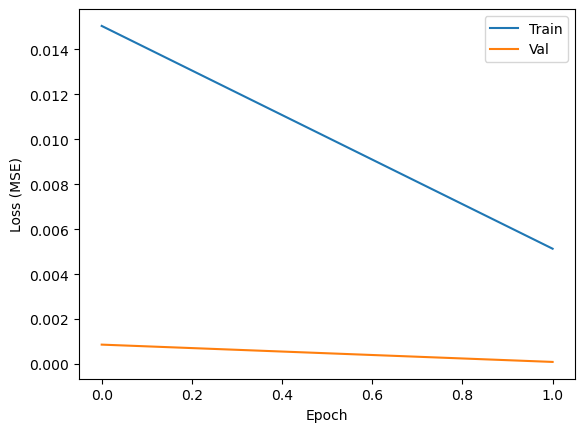

In [33]:
training_RMSEs = np.array(training_RMSEs)
validation_RMSEs = np.array(validation_RMSEs)
fig, axs = plt.subplots()
axs.plot(training_RMSEs,'-',label='Train')
axs.set_ylabel('Loss (MSE)')
axs.plot(validation_RMSEs,'-',label='Val')
axs.set_xlabel('Epoch')
axs.legend()

print(np.min(validation_RMSEs))

In [63]:
#Test model

if REMOVE_SUBS_XVAL:
    test_dataset = val_dataset
else:
    # Create the DataLoader.
    filename_r01_ordered = 'r01_ordered_corrupt_time.csv'
    filename_r01_randomized = 'r01_randomized_corrupt_time.csv'
    filename_dataport_ordered = 'dataport_ordered_corrupt_time.csv'
    filename_dataport_randomized = 'dataport_randomized_corrupt_time.csv'

    wgd_small = pd.read_csv(filename_r01_randomized,skiprows=0,nrows=2000)
    # wgd_small = pd.read_csv(filename_dataport_randomized,skiprows=0,nrows=10000)
    # wgd_small = pd.read_csv(filename_r01_randomized,skiprows=0)
    window_size = 50
    meas_scale = np.array([[-69.35951035,  27.62815047],\
                            [-456.18013759,  401.13782617],\
                            [-63.71649984,  22.06632622],\
                            [-213.4786175,   396.93801619],\
                            [-35.26603985,  20.78473636],\
                            [-20.95456523,  14.63961137],\
                              [0,1]])
    
  
    speed_scale = (0,2)
    incline_scale = (-10,10)
    do_phase_trig = True



    test_dataset = WindowedGaitDataset(gait_data=wgd_small,
                                                window_size = window_size,
                                                meas_scale = meas_scale,
                                                speed_scale = speed_scale,
                                                incline_scale = incline_scale,
                                                transform=ToTensor())    
  

# test_dataset = train_dataset
BATCH_SIZE = 1024//1
prediction_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
# Prediction on test set

print('Predicting labels for {:,} test points...'.format(len(test_dataset)))

# Model parameters
dim_val = 8 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 4 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_encoder_layers = 8 # Number of times the encoder layer is stacked in the encoder
n_decoder_layers = 2 # Number of times the encoder layer is stacked in the encoder
input_size = 1 # The number of input variables. 1 if univariate forecasting.

dropout_encoder = 0.1
dropout_decoder = 0.1 
dropout_pos_enc = 0.0
dropout_pos_dec = 0.0
dropout_regression = 0.1 
dim_feedforward_encoder = 256
dim_feedforward_decoder = 256

num_input_variables = 7
num_predicted_features = 7 # The number of output variables. 
enc_seq_len = 50*num_input_variables # length of input given to encoder. Can have any integer value.
dec_seq_len = 50*num_predicted_features # length of input given to decoder. Can have any integer value.

        
best_encoder_model = GaitTransformerSpatiotemporalEncoder(
    dim_val=dim_val,
    input_size=input_size, 
    n_encoder_layers=n_encoder_layers,
    n_heads=n_heads,
    enc_seq_len=enc_seq_len,
    dropout_encoder=dropout_encoder,
    dropout_pos_enc=dropout_pos_enc,
    num_input_variables=num_input_variables,
    dim_feedforward_encoder=dim_feedforward_encoder,
    IS_BEING_TRAINED=False)
        
best_kinematics_decoder_model = GaitTransformerSpatiotemporalKinematicsDecoder(
    dim_val=dim_val,
    input_size=input_size, 
    n_decoder_layers=n_decoder_layers,
    n_heads=n_heads,
    dec_seq_len=dec_seq_len,
    dropout_decoder=dropout_decoder,
    dropout_pos_dec=dropout_pos_dec,
    dropout_regression=dropout_regression,
    dim_feedforward_decoder=dim_feedforward_decoder,
    encoder_mask_token=best_encoder_model.mask_token,
    encoder_variable_embedding_layer=best_encoder_model.variable_embedding_layer,
    num_input_variables=num_input_variables,
    batch_first=True)

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")


# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs!")
#     # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
#     best_model = nn.DataParallel(best_model)
best_encoder_model.to(device)
best_kinematics_decoder_model.to(device)
# best_model.to(torch.device("cpu"))

model_nickname = 'ST-keter'

model_dir = f'./staging_area/{model_nickname}/model_save/'
if REMOVE_SUBS_XVAL:
    model_dir = f'./staging_area/{model_nickname}/model_save_xval/'
    
#load encoder
encoder_checkpoint = torch.load(model_dir+'ST_encoder_best_model.tar')
g = encoder_checkpoint['model_state_dict']
loss = encoder_checkpoint['loss']
print(f'Lowest Loss: {loss}')
best_encoder_model.load_state_dict(g)

#load decoder
decoder_checkpoint = torch.load(model_dir+'ST_kinematics_decoder_best_model.tar')
g = decoder_checkpoint['model_state_dict']
loss = decoder_checkpoint['loss']
print(f'Lowest Loss: {loss}')
best_kinematics_decoder_model.load_state_dict(g)

epoch = encoder_checkpoint['epoch']

# Put model in evaluation mode
best_encoder_model.eval()
best_kinematics_decoder_model.eval()

# Tracking variables 
predictions , true_labels = [], []


#Extract index for time steps
DT_IDX = 6

# variables_idxs_mask_out = [1,2,5,6]
variables_idxs_mask_out = []

def unscale_kinematics(scaled_kinematics_vec, scales):
    rows, cols = scaled_kinematics_vec.shape
    # print(gait_state_vec.shape)
    unscaled_kinematics_vec = np.zeros((rows,cols))
    
    for i in range(cols):
        scale_lb = scales[i,0]
        scale_ub = scales[i,1]
        unscaled_kinematics_vec[:,i] = (scaled_kinematics_vec[:,i] * (scale_ub - scale_lb)) + scale_lb
    
    return unscaled_kinematics_vec

    
# Measure the total predicting time for the whole run.
total_t0 = time.time()
# Predict 
print(len(prediction_dataloader))
for batch in prediction_dataloader:

    b_input = batch['meas'].to(device)
    b_state = batch['state'].to(device)
    
    dts = b_input[:,DT_IDX::num_input_variables,:]


    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      #run through the encoder
        latent, latent_masked_replaced, mask_bools = best_encoder_model(b_input,dts, 0.8, [])

        #run through decoder
        outputs, mask_bools = best_kinematics_decoder_model(tgt=b_input, src=latent_masked_replaced, dts=dts, mask_bools=mask_bools)
        
        
    # print(mask_bools[0,:])
    # input()


    # Move logits and labels to CPU
    outputs = outputs.detach().to('cpu').numpy()
    b_input = b_input.to('cpu').numpy()
  
    # Store predictions and true labels
    outputs = np.squeeze(outputs, axis=2)
    b_input = np.squeeze(b_input, axis=2)
    
    #reshape to have (batch_size, n_vars)
    
    outputs = np.reshape(outputs,(b_state.shape[0],-1,num_predicted_features))
    b_input = np.reshape(b_input,(b_state.shape[0],-1,num_predicted_features))
    
    # print(outputs.shape)
        
    
    #extract last datapoint
    b_input = b_input[:,-1,:]
    outputs = outputs[:,-1,:]
    
    
    #unscale
    outputs = unscale_kinematics(outputs, meas_scale)
    b_input = unscale_kinematics(b_input, meas_scale)
    
    


    # Store predictions and true labels
    predictions.extend(outputs.tolist())
    true_labels.extend(b_input.tolist())

print('    DONE PREDICTING')
print("Total predicting took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


Predicting labels for 4,236,734 test points...
====MASK TOKEN===
Parameter containing:
tensor([[[0., 0., 0., 0., 0., 0., 0., 0.]]], requires_grad=True)
Using GPU.
Lowest Loss: 9.463826318503497e-05
Lowest Loss: 9.463826318503497e-05
4138
pe
torch.Size([1024, 350, 8])
tensor([0.5018, 0.5018, 0.5018, 0.5018, 0.5018, 0.5018, 0.5018, 0.4915, 0.4915,
        0.4915, 0.4915, 0.4915, 0.4915, 0.4915, 0.4859, 0.4859, 0.4859, 0.4859,
        0.4859, 0.4859, 0.4859, 0.4764, 0.4764, 0.4764, 0.4764, 0.4764, 0.4764,
        0.4764, 0.4654, 0.4654, 0.4654, 0.4654, 0.4654, 0.4654, 0.4654, 0.4534,
        0.4534, 0.4534, 0.4534, 0.4534, 0.4534, 0.4534, 0.4431, 0.4431, 0.4431,
        0.4431, 0.4431, 0.4431, 0.4431, 0.4340, 0.4340, 0.4340, 0.4340, 0.4340,
        0.4340, 0.4340, 0.4265, 0.4265, 0.4265, 0.4265, 0.4265, 0.4265, 0.4265,
        0.4148, 0.4148, 0.4148, 0.4148, 0.4148, 0.4148, 0.4148, 0.4020, 0.4020,
        0.4020, 0.4020, 0.4020, 0.4020, 0.4020, 0.3921, 0.3921, 0.3921, 0.3921,
        0.39

effective_mask_ratios
0.8
pe
torch.Size([1024, 350, 8])
tensor([0.5018, 0.5018, 0.5018, 0.5018, 0.5018, 0.5018, 0.5018, 0.4915, 0.4915,
        0.4915, 0.4915, 0.4915, 0.4915, 0.4915, 0.4859, 0.4859, 0.4859, 0.4859,
        0.4859, 0.4859, 0.4859, 0.4764, 0.4764, 0.4764, 0.4764, 0.4764, 0.4764,
        0.4764, 0.4654, 0.4654, 0.4654, 0.4654, 0.4654, 0.4654, 0.4654, 0.4534,
        0.4534, 0.4534, 0.4534, 0.4534, 0.4534, 0.4534, 0.4431, 0.4431, 0.4431,
        0.4431, 0.4431, 0.4431, 0.4431, 0.4340, 0.4340, 0.4340, 0.4340, 0.4340,
        0.4340, 0.4340, 0.4265, 0.4265, 0.4265, 0.4265, 0.4265, 0.4265, 0.4265,
        0.4148, 0.4148, 0.4148, 0.4148, 0.4148, 0.4148, 0.4148, 0.4020, 0.4020,
        0.4020, 0.4020, 0.4020, 0.4020, 0.4020, 0.3921, 0.3921, 0.3921, 0.3921,
        0.3921, 0.3921, 0.3921, 0.3827, 0.3827, 0.3827, 0.3827, 0.3827, 0.3827,
        0.3827, 0.3738, 0.3738, 0.3738, 0.3738, 0.3738, 0.3738, 0.3738, 0.3655,
        0.3655, 0.3655, 0.3655, 0.3655, 0.3655, 0.3655, 0.3564, 

KeyboardInterrupt: Interrupted by user

(4236734, 7)
(4236734, 7)
Foot Angle Losses: 0.416 +- 0.226
Foot Angle Vel Losses: 2.651 +- 2.633
Shank Angle Losses: 0.312 +- 0.209
Shank Angle Vel Losses: 2.659 +- 1.202
Heel Acc Forward Losses: 0.125 +- 0.051
Heel Acc Up Losses: 0.127 +- 0.122
dt Losses: 0.008 +- 0.001


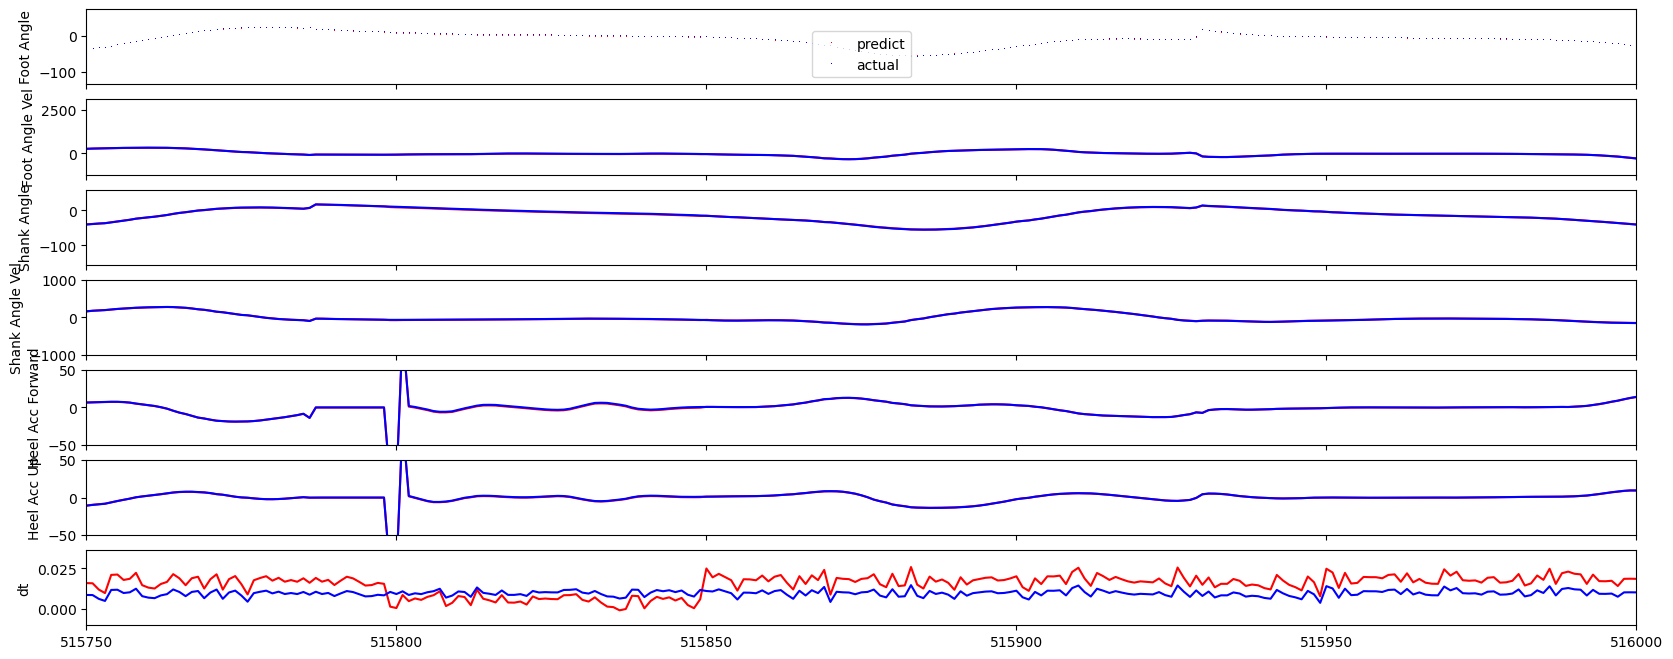

In [17]:
predictions = np.array(predictions)
true_labels = np.array(true_labels)

#bound the accels at +- 100 to filter out the occasional spikes 
predictions[:,4] = np.clip(predictions[:,4],-100,100)
predictions[:,5] = np.clip(predictions[:,5],-100,100)

true_labels[:,4] = np.clip(true_labels[:,4],-100,100)
true_labels[:,5] = np.clip(true_labels[:,5],-100,100)



print(predictions.shape)
print(true_labels.shape)

foot_angle_losses = np.sqrt((predictions[:,0] - true_labels[:,0])**2)
foot_angle_vel_losses = np.sqrt((predictions[:,1] - true_labels[:,1])**2)
shank_angle_losses = np.sqrt((predictions[:,2] - true_labels[:,2])**2)
shank_angle_vel_losses = np.sqrt((predictions[:,3] - true_labels[:,3])**2)
heel_acc_forward_losses = np.sqrt((predictions[:,4] - true_labels[:,4])**2)
heel_acc_up_losses = np.sqrt((predictions[:,5] - true_labels[:,5])**2)
dt_losses = np.sqrt((predictions[:,6] - true_labels[:,6])**2)


print("="*30)
print(f'Foot Angle Losses: {np.mean(foot_angle_losses):.3f} +- {np.std(foot_angle_losses):.3f}')
print(f'Foot Angle Vel Losses: {np.mean(foot_angle_vel_losses):.3f} +- {np.std(foot_angle_vel_losses):.3f}')
print(f'Shank Angle Losses: {np.mean(shank_angle_losses):.3f} +- {np.std(shank_angle_losses):.3f}')
print(f'Shank Angle Vel Losses: {np.mean(shank_angle_vel_losses):.3f} +- {np.std(shank_angle_vel_losses):.3f}')
print(f'Heel Acc Forward Losses: {np.mean(heel_acc_forward_losses):.3f} +- {np.std(heel_acc_forward_losses):.3f}')
print(f'Heel Acc Up Losses: {np.mean(heel_acc_up_losses):.3f} +- {np.std(heel_acc_up_losses):.3f}')
print(f'dt Losses: {np.mean(dt_losses):.3f} +- {np.std(dt_losses):.3f}')



fig, axs = plt.subplots(7,1,figsize=(20,8),sharex=True)
axs[0].plot(predictions[:,0],'r',label='predict')
axs[0].plot(true_labels[:,0],'b',label='actual')
axs[0].legend()
# axs[0].set_xlim([20000,23000])
# axs[0].set_xlim([0.3622e6,0.3725e6]) #r01 randomized mix of stairs and inclines
# axs[0].set_xlim([2e6,2.0025e6]) #dataport mix of ramps
# axs[0].set_xlim([3.175e6,3.18e6]) #ordered gt
axs[0].set_xlim([0.51575e6,0.516e6]) #contains spike

axs[0].set_ylabel('Foot Angle')

axs[1].plot(predictions[:,1],'r',label='predict')
axs[1].plot(true_labels[:,1],'b',label='actual')
axs[1].set_ylabel('Foot Angle Vel')
axs[3].set_ylim([-500,600])


axs[2].plot(predictions[:,2],'r',label='predict')
axs[2].plot(true_labels[:,2],'b',label='actual')
axs[2].set_ylabel('Shank Angle')

axs[3].plot(predictions[:,3],'r',label='predict')
axs[3].plot(true_labels[:,3],'b',label='actual')
axs[3].set_ylabel('Shank Angle Vel')
axs[3].set_ylim([-1000,1000])


axs[4].plot(predictions[:,4],'r',label='predict')
axs[4].plot(true_labels[:,4],'b',label='actual')
axs[4].set_ylabel('Heel Acc Forward')
axs[4].set_ylim([-50,50])


axs[5].plot(predictions[:,5],'r',label='predict')
axs[5].plot(true_labels[:,5],'b',label='actual')
axs[5].set_ylabel('Heel Acc Up')
axs[5].set_ylim([-50,50])

axs[6].plot(predictions[:,6],'r',label='predict')
axs[6].plot(true_labels[:,6],'b',label='actual')
axs[6].set_ylabel('dt')
plt.show()


In [13]:
#Now we train the gait decoder 

#setup parameters for the best ST encoder
encoder_dim_val = 8 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 4 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_encoder_layers = 8 # Number of times the encoder layer is stacked in the encoder
input_size = 1 # The number of input variables. 1 if univariate forecasting.

dropout_encoder = 0.1
dropout_pos_enc = 0.0
dropout_regression = 0.1 
dim_feedforward_encoder = 256

num_encoder_input_variables = 7
enc_seq_len = 50*num_encoder_input_variables # length of input given to encoder. Can have any integer value.
        
best_encoder_model = GaitTransformerSpatiotemporalEncoder(
    dim_val=encoder_dim_val,
    input_size=input_size, 
    n_encoder_layers=n_encoder_layers,
    n_heads=n_heads,
    enc_seq_len=enc_seq_len,
    dropout_encoder=dropout_encoder,
    dropout_pos_enc=dropout_pos_enc,
    num_input_variables=num_encoder_input_variables,
    dim_feedforward_encoder=dim_feedforward_encoder,
    IS_BEING_TRAINED=True)

#load in best ST encoder
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")


# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs!")
#     # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
#     best_model = nn.DataParallel(best_model)
best_encoder_model.to(device)

model_nickname = 'ST-keter'

model_dir = f'./staging_area/{model_nickname}/model_save/'
if REMOVE_SUBS_XVAL:
    model_dir = f'./staging_area/{model_nickname}/model_save_xval/'
    
#load encoder
encoder_checkpoint = torch.load(model_dir+'ST_encoder_best_model.tar')
g = encoder_checkpoint['model_state_dict']
loss = encoder_checkpoint['loss']
print(f'Lowest Loss: {loss}')
best_encoder_model.load_state_dict(g)

epoch = encoder_checkpoint['epoch']

# Put model in evaluation mode
best_encoder_model.eval()
enum_parameters(best_encoder_model)

print('LOADED ST ENCODER')

#NOW INITIALIZE IN THE GAIT DECODER
dim_val = 32
n_decoder_layers = 8
dropout_decoder = 0.1 
dropout_pos_dec = 0.0
dropout_regression = 0.1 
dim_feedforward_decoder = 512

num_decoder_input_variables = 6
num_predicted_features = 6 # The number of output variables, again, just for human convenience
dec_seq_len = 1*num_predicted_features # length of input given to decoder. Can have any integer value.


gait_state_decoder_model = GaitTransformerSpatiotemporalGaitStateDecoder(
    dim_val=dim_val,
    encoder_dim_val=encoder_dim_val,
    input_size=input_size, 
    n_decoder_layers=n_decoder_layers,
    n_heads=n_heads,
    dec_seq_len=dec_seq_len,
    dropout_decoder=dropout_decoder,
    dropout_pos_dec=dropout_pos_dec,
    dropout_regression=dropout_regression,
    dim_feedforward_decoder=dim_feedforward_decoder,
    num_input_variables=num_decoder_input_variables,
    batch_first=True)


enum_parameters(gait_state_decoder_model)

gait_state_decoder_model.to(device)


best_model_name_decoder = 'ST_gait_state_decoder_best_model.tar'
save_best_model_decoder = SaveBestModel(output_dir+best_model_name_decoder)
print('SET UP ST GAIT STATE DECODER')


optimizer = torch.optim.Adam(gait_state_decoder_model.parameters(), lr=0.001, betas=(0.9, 0.998), eps=1e-9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=0, threshold=0.01, verbose=True,min_lr=1e-6)

start_epoch = 0
FROM_CHECKPOINT = not True
if FROM_CHECKPOINT:

    #load decoder
    decoder_checkpoint = torch.load(model_dir+'ST_gait_state_decoder_best_model.tar')
    g = decoder_checkpoint['model_state_dict']
    loss = decoder_checkpoint['loss']
    print(f'Lowest Loss: {loss}')
    kinematics_decoder_model.load_state_dict(g)

    save_best_model_decoder = SaveBestModel(model_dir+best_model_name_decoder, loss)

    optimizer.load_state_dict(decoder_checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f'From epoch: {start_epoch}')



epochs = 3
SAVE_EVERY_EPOCH_N = 1
first_batch = next(iter(train_dataloader))

lossfcn = GaitLossST(w_phase=2, w_speed=1, w_incline=1, w_stairs=1, w_moving=1)

#Extract index for time steps
DT_IDX = 6

#Set up start of sequence token
SOS_token_gait_estimator = 10 * torch.ones(1, dec_seq_len,1).to(device).requires_grad_(False)


training_RMSEs = []
validation_RMSEs = []


# Measure the total training time for the whole run.
total_t0 = time.time()

print('===================GAIT STATE DECODER====================')

for epoch_i in range(start_epoch, start_epoch+epochs):
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, start_epoch+epochs))
    print('Training...')
    
    # lr = scheduler.get_lr()
    lr = optimizer.param_groups[0]['lr']
    print(f'Learning Rate: {lr}')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    gait_state_decoder_model.train()
    step_ct = 0
    for step, batch in enumerate(train_dataloader):
        step_ct += 1
        # for step, batch in enumerate([first_batch] * 200):

        
        optimizer.zero_grad()   
        
        b_kinematics = batch['meas'].to(device)
        b_state = batch['state'].to(device)
        
        
        tgt_gait_estimator = SOS_token_gait_estimator.repeat(b_state.shape[0], 1, 1)
        
        # print('tgt_gait_estimator')
        # print(tgt_gait_estimator.shape)
        dts = b_kinematics[:,DT_IDX::num_encoder_input_variables,:]
        
        #run through the ST encoder
        latent, latent_masked_replaced, mask_bools = best_encoder_model(b_kinematics,dts, 0, [])
        
        
        # Forward pass through the gait state estimator
        predicted_gait_state = gait_state_decoder_model(tgt=tgt_gait_estimator, src=latent_masked_replaced, dts=dts)
        
        # print('predicted_gait_state')
        # print(predicted_gait_state.shape)
        
        # print('b_state')
        # print(b_state.shape)
        loss = lossfcn(predicted_gait_state, b_state)
        # print(loss)

        loss.backward()

        optimizer.step()

        loss_value = loss.item()

        # Progress update every 40 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            print(loss_value)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss_value
        
    # Update the learning rate.
    #if StepLR
    # scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / step_ct           
    training_RMSEs.append(avg_train_loss)
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    
    # Save to checkpoints
    if (epoch_i + 1) % SAVE_EVERY_EPOCH_N == 0:
        print('Saving model checkpoint')
        decoder_model_name = f"ST_gait_state_decoder_checkpoint_{epoch_i + 1}.tar"
        path_name = output_dir+checkpoint_dir+decoder_model_name
        print(path_name)
        torch.save({
                    'epoch':epoch_i + 1,
                    'model_state_dict': gait_state_decoder_model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item(),
                    }, path_name)

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    gait_state_decoder_model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    
    
    step_ct = 0
    for batch in validation_dataloader:
    #for batch in train_dataloader:
    # for step, batch in enumerate([first_batch] * 10):
        step_ct += 1

        b_kinematics = batch['meas'].to(device)
        b_state = batch['state'].to(device)
        
        tgt_gait_estimator = SOS_token_gait_estimator.repeat(b_state.shape[0], 1, 1)
    
        dts = b_kinematics[:,DT_IDX::num_encoder_input_variables,:]
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            
            #run through the ST encoder
            latent, latent_masked_replaced, mask_bools = best_encoder_model(b_kinematics,dts, 0, [])
            
            # Forward pass through the gait state estimator
            predicted_gait_state = gait_state_decoder_model(tgt=tgt_gait_estimator, src=latent_masked_replaced, dts=dts)
        
            

        loss = lossfcn(predicted_gait_state, b_state)
        #print(loss)
        loss_value = loss.item()
        #print(loss_rmse)

        

        # Accumulate the validation loss.
        total_eval_loss += loss_value


    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / step_ct
    
    #schedule PlateauLoss
    scheduler.step(avg_val_loss)
    
    validation_RMSEs.append(avg_val_loss)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.4f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    
    #save best model
    save_best_model_decoder(
        avg_val_loss, epoch_i+1, gait_state_decoder_model, optimizer, lossfcn
    )
    
    #print training vals
    print('Training vals')
    print(validation_RMSEs)

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

print("Saving model to %s" % output_dir)

decoder_model_name = 'ST_gait_state_decoder_params.pt'
torch.save(gait_state_decoder_model.state_dict(), output_dir+decoder_model_name)

#save entire model
decoder_model_name = 'ST_gait_state_decoder_full.pt'
torch.save(gait_state_decoder_model, output_dir+decoder_model_name)


====MASK TOKEN===
Parameter containing:
tensor([[[0., 0., 0., 0., 0., 0., 0., 0.]]], requires_grad=True)
Using GPU.
Lowest Loss: 9.463826318503497e-05
Total Trainable Params: 37520
LOADED ST ENCODER
Total Trainable Params: 40033
SET UP ST GAIT STATE DECODER
===================GAIT STATE DECODER====================

======== Epoch 1 / 3 ========
Training...
Learning Rate: 0.001
  Batch   100  of  176,830.    Elapsed: 0:00:14.
4.895103454589844
  Batch   200  of  176,830.    Elapsed: 0:00:27.
4.606385707855225
  Batch   300  of  176,830.    Elapsed: 0:00:40.
3.355550765991211
  Batch   400  of  176,830.    Elapsed: 0:00:52.
2.8961217403411865
  Batch   500  of  176,830.    Elapsed: 0:01:05.
2.8247270584106445
  Batch   600  of  176,830.    Elapsed: 0:01:18.
2.6628270149230957
  Batch   700  of  176,830.    Elapsed: 0:01:31.
2.567784309387207
  Batch   800  of  176,830.    Elapsed: 0:01:43.
2.528078079223633
  Batch   900  of  176,830.    Elapsed: 0:01:56.
2.309086561203003
  Batch 1,000 

KeyboardInterrupt: 

In [ ]:
training_RMSEs = np.array(training_RMSEs)
validation_RMSEs = np.array(validation_RMSEs)
fig, axs = plt.subplots()
axs.plot(training_RMSEs,'-',label='Train')
axs.set_ylabel('Loss (MSE)')
axs.plot(validation_RMSEs,'-',label='Val')
axs.set_xlabel('Epoch')
axs.legend()

print(np.min(validation_RMSEs))

In [ ]:
#Test model

if REMOVE_SUBS_XVAL:
    test_dataset = val_dataset
else:
    # Create the DataLoader.
    filename_r01_ordered = 'r01_ordered_corrupt_time.csv'
    filename_r01_randomized = 'r01_randomized_corrupt_time.csv'
    filename_dataport_ordered = 'dataport_ordered_corrupt_time.csv'
    filename_dataport_randomized = 'dataport_randomized_corrupt_time.csv'

    wgd_small = pd.read_csv(filename_r01_randomized,skiprows=0,nrows=2000)
    # wgd_small = pd.read_csv(filename_dataport_randomized,skiprows=0,nrows=10000)
    # wgd_small = pd.read_csv(filename_r01_randomized,skiprows=0)
    window_size = 50
    meas_scale = np.array([[-69.35951035,  27.62815047],\
                            [-456.18013759,  401.13782617],\
                            [-63.71649984,  22.06632622],\
                            [-213.4786175,   396.93801619],\
                            [-35.26603985,  20.78473636],\
                            [-20.95456523,  14.63961137],\
                              [0,1]])
    
  
    speed_scale = (0,2)
    incline_scale = (-10,10)
    do_phase_trig = True



    test_dataset = WindowedGaitDataset(gait_data=wgd_small,
                                                window_size = window_size,
                                                meas_scale = meas_scale,
                                                speed_scale = speed_scale,
                                                incline_scale = incline_scale,
                                                transform=ToTensor())    
  

# test_dataset = train_dataset
BATCH_SIZE = 1024//1
prediction_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
# Prediction on test set

print('Predicting labels for {:,} test points...'.format(len(test_dataset)))


#setup parameters for the best ST encoder
encoder_dim_val = 8 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 4 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_encoder_layers = 8 # Number of times the encoder layer is stacked in the encoder
input_size = 1 # The number of input variables. 1 if univariate forecasting.

dropout_encoder = 0.1
dropout_pos_enc = 0.0
dropout_regression = 0.1 
dim_feedforward_encoder = 256
dim_feedforward_decoder = 256

num_encoder_input_variables = 7
enc_seq_len = 50*num_encoder_input_variables # length of input given to encoder. Can have any integer value.
        
best_encoder_model = GaitTransformerSpatiotemporalEncoder(
    dim_val=encoder_dim_val,
    input_size=input_size, 
    n_encoder_layers=n_encoder_layers,
    n_heads=n_heads,
    enc_seq_len=enc_seq_len,
    dropout_encoder=dropout_encoder,
    dropout_pos_enc=dropout_pos_enc,
    num_input_variables=num_encoder_input_variables,
    dim_feedforward_encoder=dim_feedforward_encoder,
    IS_BEING_TRAINED=True)


#load in best decoder
#NOW INITIALIZE IN THE GAIT DECODER
dim_val = 8
n_decoder_layers = 4
dropout_decoder = 0.1 
dropout_pos_dec = 0.0
dropout_regression = 0.1 
dim_feedforward_decoder = 256

num_decoder_input_variables = 6
num_predicted_features = 6 # The number of output variables, again, just for human convenience
dec_seq_len = 1*num_predicted_features # length of input given to decoder. Can have any integer value.


best_gait_state_decoder_model = GaitTransformerSpatiotemporalGaitStateDecoder(
    dim_val=dim_val,
    encoder_dim_val=encoder_dim_val,
    input_size=input_size, 
    n_decoder_layers=n_decoder_layers,
    n_heads=n_heads,
    dec_seq_len=dec_seq_len,
    dropout_decoder=dropout_decoder,
    dropout_pos_dec=dropout_pos_dec,
    dropout_regression=dropout_regression,
    dim_feedforward_decoder=dim_feedforward_decoder,
    num_input_variables=num_decoder_input_variables,
    batch_first=True)



#load in best ST encoder
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")


# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs!")
#     # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
#     best_model = nn.DataParallel(best_model)
best_encoder_model.to(device)
best_gait_state_decoder_model.to(device)


model_nickname = 'ST-keter'

model_dir = f'./staging_area/{model_nickname}/model_save/'
if REMOVE_SUBS_XVAL:
    model_dir = f'./staging_area/{model_nickname}/model_save_xval/'

    
#load encoder
encoder_checkpoint = torch.load(model_dir+'ST_encoder_best_model.tar')
g = encoder_checkpoint['model_state_dict']
loss = encoder_checkpoint['loss']
print(f'Lowest Loss: {loss}')
best_encoder_model.load_state_dict(g)

epoch = encoder_checkpoint['epoch']

enum_parameters(best_encoder_model)
enum_parameters(best_gait_state_decoder_model)


#load decoder
decoder_checkpoint = torch.load(model_dir+'ST_gait_state_decoder_best_model.tar')
g = decoder_checkpoint['model_state_dict']
loss = decoder_checkpoint['loss']
print(f'Lowest Loss: {loss}')
best_gait_state_decoder_model.load_state_dict(g)
print('LOADED ST MODELS')


# Put model in evaluation mode
best_encoder_model.eval()
best_gait_state_decoder_model.eval()

# Tracking variables 
predictions , true_labels = [], []


#Extract index for time steps
DT_IDX = 6


#Set up start of sequence token
SOS_token_gait_estimator = 10 * torch.ones(1, dec_seq_len,1).to(device).requires_grad_(False)


def phase_dist(phase_a, phase_b):
    """computes a distance that accounts for the modular arithmetic of phase
    and guarantees that the output is between 0 and .5
    
    Args:
        phase_a (float): a phase between 0 and 1
        phase_b (float): a phase between 0 and 1
    
    Returns:
        dist_prime: the difference between the phases, modulo'd between 0 and 0.5
    """
    if isinstance(phase_a, np.ndarray):
        dist_prime = (phase_a-phase_b)
        dist_prime[dist_prime > 0.5] = 1-dist_prime[dist_prime > 0.5]

        dist_prime[dist_prime < -0.5] = -1-dist_prime[dist_prime < -0.5]

    else:
        dist_prime = (phase_a-phase_b)
        if dist_prime > 0.5:
            dist_prime = 1-dist_prime

        elif dist_prime < -0.5:
            dist_prime = -1-dist_prime
    return dist_prime



def unscale_gait_state(gait_state_vec, speed_scale, incline_scale):
    rows, cols = gait_state_vec.shape
    # print(gait_state_vec.shape)
    gait_state_unscaled = np.zeros((rows,cols-1))
    
    cp = gait_state_vec[:,0]
    sp = gait_state_vec[:,1]
    
    #undo the trig on phase
    x = np.arctan2(sp,cp)
    phase_p = ((x)/(2*np.pi)) + 0.5
    
    gait_state_unscaled[:,0] = phase_p
    
    #unscale speed
    speed_lb = speed_scale[0]
    speed_ub = speed_scale[1]
    speed_unscaled = (gait_state_vec[:,2] * (speed_ub - speed_lb)) + speed_lb
    gait_state_unscaled[:,1] = speed_unscaled
    
    #unscale incline
    incline_lb = incline_scale[0]
    incline_ub = incline_scale[1]
    incline_unscaled = (gait_state_vec[:,3] * (incline_ub - incline_lb)) + incline_lb
    gait_state_unscaled[:,2] = incline_unscaled
    
    #add rest of gait state variables
    gait_state_unscaled[:,3:] = gait_state_vec[:,4:]
    
    return gait_state_unscaled

    
# Measure the total predicting time for the whole run.
total_t0 = time.time()
# Predict 
print(len(prediction_dataloader))
for batch in prediction_dataloader:
    
    b_kinematics = batch['meas'].to(device)
    b_state = batch['state'].to(device)


    tgt_gait_estimator = SOS_token_gait_estimator.repeat(b_state.shape[0], 1, 1)

    # print('tgt_gait_estimator')
    # print(tgt_gait_estimator.shape)
    # print(tgt_gait_estimator.device)
    dts = b_kinematics[:,DT_IDX::num_encoder_input_variables,:]


    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
          #run through the ST encoder
        latent, latent_masked_replaced, mask_bools = best_encoder_model(b_kinematics,dts, 0, [])


        # Forward pass through the gait state estimator
        outputs = best_gait_state_decoder_model(tgt=tgt_gait_estimator, src=latent_masked_replaced, dts=dts)
        # print(outputs)


    # Move logits and labels to CPU
    outputs = outputs.detach().to('cpu').numpy()
    b_state = b_state.to('cpu').numpy()
  
    # Store predictions and true labels
    outputs = np.squeeze(outputs, axis=2)
    b_state = np.squeeze(b_state, axis=2)
    
    
    # print(outputs.shape)
        
    
    #unscale
    outputs = unscale_gait_state(outputs, speed_scale, incline_scale)
    b_state = unscale_gait_state(b_state, speed_scale, incline_scale)
    
    


    # Store predictions and true labels
    predictions.extend(outputs.tolist())
    true_labels.extend(b_state.tolist())

print('    DONE PREDICTING')
print("Total predicting took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


In [ ]:
predictions = np.array(predictions)
true_labels = np.array(true_labels)

phase_losses = np.sqrt(phase_dist(predictions[:,0], true_labels[:,0])**2)
speed_losses = np.sqrt((predictions[:,1] - true_labels[:,1])**2)
incline_losses = np.sqrt((predictions[:,2] - true_labels[:,2])**2)
# incline_losses_no_stairs = np.sqrt((predictions[true_labels[:,3]==0,2] - true_labels[true_labels[:,3]==0,2])**2)

is_stairs_accuracy = np.sum(np.round(true_labels[:,3]) == np.round(predictions[:,3]))/len(true_labels[:,3])
# is_stairs_accuracy = np.sum(np.round(true_labels[np.round(true_labels[:,3])==1,3]) == np.round(predictions[np.round(true_labels[:,3])==1,3]))/len(true_labels[np.round(true_labels[:,3])==1,3])

is_moving_accuracy = np.sum(np.round(true_labels[:,4]) == np.round(predictions[:,4]))/len(true_labels[:,4])

print(predictions.shape)

print("="*30)
print(f'Phase Losses: {np.mean(phase_losses):.3f} +- {np.std(phase_losses):.3f}')
print(f'Speed Losses: {np.mean(speed_losses):.3f} +- {np.std(speed_losses):.3f}')
print(f'Incline Losses: {np.mean(incline_losses):.3f} +- {np.std(incline_losses):.3f}')
# print(f'Incline Losses, No stairs: {np.mean(incline_losses_no_stairs):.3f} +- {np.std(incline_losses_no_stairs):.3f}')
print(f'Is Stairs Accuracy: {is_stairs_accuracy:.3f}')
print(f'Is Moving Accuracy: {is_moving_accuracy:.3f}')

print(predictions.shape)



fig, axs = plt.subplots(5,1,figsize=(20,8),sharex=True)
axs[0].plot(predictions[:,0],'r',label='predict')
axs[0].plot(true_labels[:,0],'b',label='actual')
axs[0].legend()
# axs[0].set_xlim([9000,20000])
# axs[0].set_xlim([0.5e6,0.5e6+5000])
# axs[0].set_xlim([80,250000])
# axs[0].set_xlim([80+1000,0.05e6+1000])
axs[0].set_xlim([0.3622e6,0.3725e6]) #r01 randomized mix of stairs and inclines
# axs[0].set_xlim([0.25e6,0.26e6])
# axs[0].set_xlim([2e6,2.02e6]) #dataport mix of ramps
# axs[0].set_xlim([0.15e6,0.16e6])
# axs[0].set_xlim([3.175e6,3.19e6]) #ordered gt
axs[0].set_ylabel('Phase')

axs[1].plot(predictions[:,1],'r',label='predict')
axs[1].plot(true_labels[:,1],'b',label='actual')
axs[1].set_ylabel('Speed (m/s)')
axs[1].set_ylim([-1.25,2])


axs[2].plot(predictions[:,2],'r',label='predict')
axs[2].plot(true_labels[:,2],'b',label='actual')
axs[2].set_ylabel('Incline (deg)')
# axs[2].set_ylim([-15,15])

axs[3].plot(predictions[:,3],'r.',label='predict')
axs[3].plot(true_labels[:,3],'b',label='actual')
axs[3].set_ylabel('Is Stairs')
axs[3].set_ylim([-0.2,1.2])

axs[4].plot(predictions[:,4],'r.',label='predict')
axs[4].plot(true_labels[:,4],'b',label='actual')
axs[4].set_ylabel('Is Moving')
axs[4].set_ylim([-0.2,1.2])


In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

model_dir = f'./full_models/{model_nickname}/model_save/'
if REMOVE_SUBS_XVAL:
    model_dir = f'./full_models/{model_nickname}/model_save_xval/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

#save model params
model_name = 'ml_gait_estimator_dec_params.pt'
torch.save(model.state_dict(), output_dir+model_name)

model_name = 'ml_gait_estimator_dec.pt'
torch.save(model, output_dir+model_name)


In [ ]:
params = list(model.named_parameters())
print('The model has {:} different named parameters.\n'.format(len(params)))
for p in params:
    # print('p')
    # print(p[0])
    # print(p[1].data)
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)


In [12]:
!gsutil cp -r staging_area/ST-keter full_models/
!zip -r full_models/ST-keter.zip full_models/ST-keter/

Copying file://staging_area/ST-keter/model_save_xval/ST_gait_state_decoder_best_model.tar...
Copying file://staging_area/ST-keter/model_save_xval/ST_encoder_full.pt...      
Copying file://staging_area/ST-keter/model_save_xval/ST_kinematics_decoder_full.pt...
Copying file://staging_area/ST-keter/model_save_xval/ST_kinematics_decoder_params.pt...
/ [4 files][  4.7 MiB/  4.7 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://staging_area/ST-keter/model_save_xval/ST_encoder_params.pt...
Copying file://staging_area/ST-keter/model_save_xval/ST_encoder_best_model.tar...
Copying file://staging_area/ST-keter/model_save_xval/ST_kinematics_decoder_best_model.tar...
Copying file://staging_area/ST-keter/model_save_xval/checkpoints/ST

In [13]:
!gsutil cp -r full_models/ST-keter/ gs://ml_gait_estimation/full_models/
!gsutil cp full_models/ST-keter.zip gs://ml_gait_estimation/full_models/



Copying file://full_models/ST-keter/model_save_xval/ST_gait_state_decoder_best_model.tar [Content-Type=application/x-tar]...
Copying file://full_models/ST-keter/model_save_xval/ST_encoder_full.pt [Content-Type=application/octet-stream]...
Copying file://full_models/ST-keter/model_save_xval/ST_kinematics_decoder_full.pt [Content-Type=application/octet-stream]...
Copying file://full_models/ST-keter/model_save_xval/ST_kinematics_decoder_params.pt [Content-Type=application/octet-stream]...
- [4 files][  4.7 MiB/  4.7 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://full_models/ST-keter/model_save_xval/ST_encoder_params.pt [Content-Type=application/octet-stream]...
Copying file://full_models/ST-keter/model_save_xval/ST_encod